### Home Credit Default Risk - Phase 2

**DataSet Link**: https://www.kaggle.com/c/home-credit-default-risk/data


**DATA DESCRIPTION**

* The Home Credit Group released the 'Home Credit Default Risk' dataset three years ago. This dataset may be used to forecast how successfully a customer with no credit history would repay a loan. This data is divided into two files: application_train/test.csv, which is the primary table, and Train (with TARGET) and Test (without TARGET). 
* All prior credits given by other financial institutions that were reported to Credit Bureau are contained in Bureau.csv.
* Bureau balance.csv is a spreadsheet that provides monthly credit bureau balances and other information. There are a total of ten CSV files. The overall file size is 2.68 GB.
* POS_CASH_balance.csv is a monthly balance snapshot of the applicant's prior POS (point of sale) and cash loans with Home Credit. Each month of history of every prior credit in Home Credit (consumer credit and cash loans) connected to loans in our sample has one row in this table.
* Monthly balance snapshots of prior credit cards that the applicant holds with Home Credit are contained in Credit_card_balance.csv. This table contains one row for each month of history for every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – that is, the table contains (#loans in sample * # of relative previous credit cards * # of months where we have some history observable for the previous credit card) rows.
* All prior applications for Home Credit loans of consumers who have loans in our sample are contained in the previous_application.csv. In our data set, there is one entry for each previous loan application.
* Repayment history for previously disbursed credits in Home Credit connected to the loans in our sample is contained in the Installments_payments.csv file. There is a row for each payment paid, as well as a row for each missed payment. In our sample, one row is one payment of one installment OR one installment equals one payment of one prior Home Credit credit connected to loans.
* The file HomeCredit_columns_description.csv offers descriptions for the different data files' columns.


## Tasks to be tackled :

- Use external files like bureau.csv, bureau_balance.csv, credit_card_balance.csv as features in our current training dataset from phase 1, so that there are more features for the model to be trained on and carefully deal with the joining and preprocessing of the data.
- Perform feature engineering by creating new features and use the existing features in a way that helps the model accuracy
- Perform Hyperparameter tuning for the Logistic Regression and Random Forest Classifier Models to get the best parameters for the models.
- Select the best model out of these models and generate predictions for the test model to get the ROC score for the model.<br>

 **`Approach`**
- Join the data with the application train and test file. 
- Keeping the imputing strategy intact for the original train and test files, we removed the low correlation categorical columns and imputed the numerical data with their medians for the missing values as we observed that certain values exploded the means.
- Create new features and experimented with the modeling where there were a few newly created features that gave a high correlation with the target variable
- Performed multiple hyperparameter selection loops to get the best values for respective models
* Generated results using the best model.


In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('C:/Users/12169/Desktop/Home-Credit-Default-Risk-main/data/application_train.csv')
df_test = pd.read_csv('C:/Users/12169/Desktop/Home-Credit-Default-Risk-main/data/application_test.csv')

In [3]:
bureau = pd.read_csv('C:/Users/12169/Desktop/Home-Credit-Default-Risk-main/data/bureau.csv')
bureau_balance = pd.read_csv('C:/Users/12169/Desktop/Home-Credit-Default-Risk-main/data/bureau_balance.csv')

In [4]:
df_inst = pd.read_csv('C:/Users/12169/Desktop/Home-Credit-Default-Risk-main/data/installments_payments.csv')
df_pos_c_bal = pd.read_csv('C:/Users/12169/Desktop/Home-Credit-Default-Risk-main/data/POS_CASH_balance.csv')
df_prev_app=pd.read_csv('C:/Users/12169/Desktop/Home-Credit-Default-Risk-main/data/previous_application.csv')
credit_card_bal = pd.read_csv('C:/Users/12169/Desktop/Home-Credit-Default-Risk-main/data/credit_card_balance.csv')

In [5]:
df_inst = df_inst.select_dtypes(exclude='object')
df_pos_c_bal = df_pos_c_bal.select_dtypes(exclude='object')
df_prev_app = df_prev_app.select_dtypes(exclude='object')
credit_card_bal = credit_card_bal.select_dtypes(exclude='object')

In [6]:
df_inst= df_inst.groupby('SK_ID_CURR').median()
df_pos_c_bal = df_pos_c_bal.groupby('SK_ID_CURR').median()
credit_card_bal = credit_card_bal.groupby('SK_ID_CURR').median()
df_prev_app = df_prev_app.groupby('SK_ID_CURR').median()

In [7]:
#from google.colab import drive 
#drive.mount('/content/drive')
m_a_bu_bal = pd.merge(left=bureau, right=bureau_balance, how='left', left_on='SK_ID_BUREAU', right_on='SK_ID_BUREAU')

In [12]:
m_a_bu_bal = m_a_bu_bal.drop_duplicates()

m_a_bu_bal.shape

m_a_bu_bal = m_a_bu_bal.groupby(['SK_ID_CURR','SK_ID_BUREAU']).min()

In [13]:
# m_a_bu_bal = m_a_bu_bal.drop_duplicates()

# m_a_bu_bal.shape

# m_a_bu_bal = m_a_bu_bal.groupby(['SK_ID_CURR','SK_ID_BUREAU']).min()

new_bb = m_a_bu_bal[['DAYS_CREDIT','DAYS_ENDDATE_FACT','AMT_CREDIT_SUM','DAYS_CREDIT_UPDATE','MONTHS_BALANCE']]

new_bb = new_bb.reset_index()
# new_bb.drop(columns = ['SK_ID_BUREAU'], inplace = True)

new_bb = new_bb.groupby('SK_ID_CURR').median()

new_bb = new_bb.reset_index()

In [14]:
new_bb.head()

,SK_ID_CURR,SK_ID_BUREAU,DAYS_CREDIT,DAYS_ENDDATE_FACT,AMT_CREDIT_SUM,DAYS_CREDIT_UPDATE,MONTHS_BALANCE
0,100001,5896633.0,-857.0,-715.0,168345.00,-155.0,-28.0
1,100002,6158905.5,-1042.5,-939.0,54130.50,-402.5,-34.0
2,100003,5885878.5,-1205.5,-621.0,92576.25,-545.0,NaN
3,100004,6829133.5,-867.0,-532.5,94518.90,-532.0,NaN
4,100005,6735201.0,-137.0,-123.0,58500.00,-31.0,-4.0


In [15]:
# new_bb.drop(columns = ['Unnamed: 0'],inplace=True)

In [16]:
new_bb = new_bb.select_dtypes(exclude='object')

# **EXPLORATORY DATA ANALYSIS + FEATURE ENGINEERING AND TRANSFORMERS**



**Feature Engineering:** 
<br/>
`Phase1`
* The first step to deal with the data was to remove the columns which would act as redundant as it would not contribute in prediction.We explored the data and saw the number of missing values. We removed the columns which had more than 50% of missing values. We checked the columns for the number of 0's distribution and removed the columns which has 90% rows with only values as 0's.
* Further more we divided the data to identify if it is Numerical and categorical. The numerical data was dealt by creating an intermediate Imputer pipleine where the numerical missing values were replaced with the mean of the the data and the missing values in Categorical missing data was dealt by performing OHE(One hot Encoding) and replacing the missing values with Mode of the columns.
<br/>
`Phase2`
* We found out the important  features for this home credit risk prediction by finding out their correlation with the target variable.
These were the steps we followed as an updation to the phase 1 feature engineering:
* We merged the following files to the main appication_train and application_test file - bureau_balance, bureau, installments_payments, POS_CASH_balance, previous_application
* After merging these files with the application_train file we experimented with the added features to generate new features
* The following are the new features that we added    
    **Feature 1** - AMT_TOTAL_RECEIVABLE/AMT_BALANCE
        Assuming that the total amount receivable is the expected loan amount by the client and the amount receivable is the final amount the individual is going to get,we take in the consideration that the ratio of amount balance  receivable by amount  will give us the final result.    
    **Feature 2** : AMT_TOTAL_RECEIVABLE/AMT_RECIVABLE
        Assuming that the total amount receivable is the expected loan amount by the client and the amount receivable is the final amount the individual is going to get,we take in the consideration that the ratio of amount balance  receivable by amount  will give us the final result.
    **Feature 3** : AMT_TOTAL_RECEIVABLE/AMT_RECIVABLE_PRINCIPAL
        Assuming that the total amount receivable is the expected loan amount by the client and the amount receivable principal is the principal  amount the individual is going to get,we take in the consideration that the ratio receivable by principal amount  will give us the final result.
    **Feature 4** - AMT_BALANCE/AMT_RECEIVABLE    
        Assuming that the amount balance is receivable is the expected loan amount by the client and the amount receivable is the final amount the individual is going to get,we take in the consideration that the ratio of amount balance  receivable by amount  will give us the final result.
    **Feature 5** : AMT_BALANCE/AMT_RECEIVABLE_PRINCIPAL
        Assuming that the amount balance is the amount left  by the client and the amount receivable is the principal amount the individual is going to get,we take in the consideration that the ratio will give us the final result.
    **Feature 6** : AMT_RECIVABLE/AMT_RECEIVABLE_PRINCIPAL
        Assuming that the total amount receivable is the expected loan amount by the client and the amount receivable principal  is the principal amount the individual is going to get,we take in the consideration that the ratio of amount receivable  receivable by principal amount  will give us the final result.
* We had noticed that the features of EXT_SOURCE had a high correlation with the Target, and looked discriminatory between the Defaulters and Non-Defaulters too, hence we created new features from that features as:<br/> <br/>
    **Feature 7** - (EXT_SOURCE_1+EXT_SOURCE_2+EXT_SOURCE_3)/AMT_RECIVABLE
        Sum of the sources divided by the amount receivable by the customer.
    **Feature 8** -  EXT_SOURCE_1+EXT_SOURCE_2+EXT_SOURCE_3
        Sum of the external sources
    **Feature 9** -  EXT_SOURCE_1*EXT_SOURCE_2*EXT_SOURCE_3
        Multiplication of the external resources
    **Feature 10** - EXT_SOURCE_1*2+EXT_SOURCE_2*3+EXT_SOURCE_3*4
        Weighted average of the external resources.
    **Feature 11** - Max of (EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3)
        Maximum of the 3 columns of external resources. 


* We along with the features now select all those columns that have a  correlation of more than 5% or 0.05 with the target variable. 
* After obtaining these columns we dealt with their missing values by replacing them with the median of that column.
* Finally we get the columns which we are going to include in our final application train dataframe.
* Since Naive Bayes did not yield better results than the last phase and had a really low accuracy we discarded it in this phase. This phase we will consider only 2 models namely a Logistic Regression model and a Random Forest Classifier model.
* After getting the final dataset we put this data in the pipeline and the pipeline alongside the step of StandardScaler this time consists of GridSearch cross validation to get the best parameters in Logistic Regression(ie C) and Random Forest Classifier(ie max_features, max_depth, n_estimators, criterion).
* After the search for best parameters, we fit the training data in the best models and get the accuracy for the training set and the validation set.
* The next step would be to put the merged test data into the best model amongst the two models that we got and submit it to Kaggle.


* Here is a small snippet representing the experiments we performed with the features:


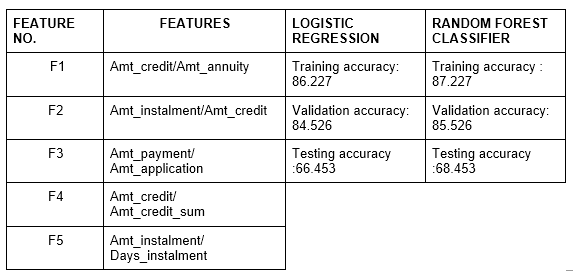

* The above features have a low correlation with the target variable.
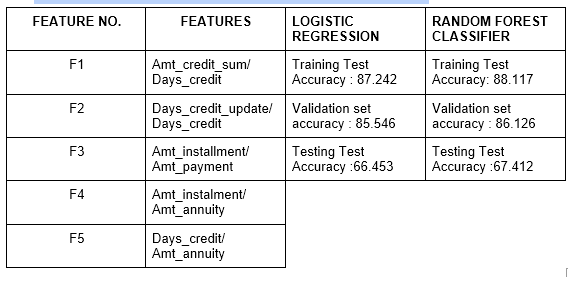

* The above features have a low correlation with the target variable.
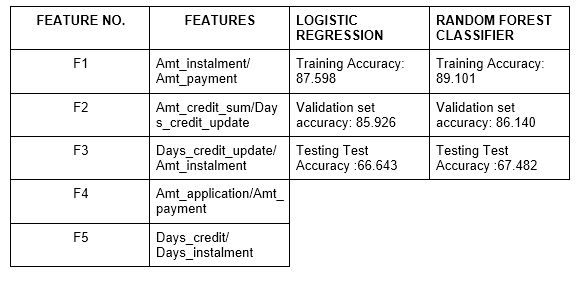

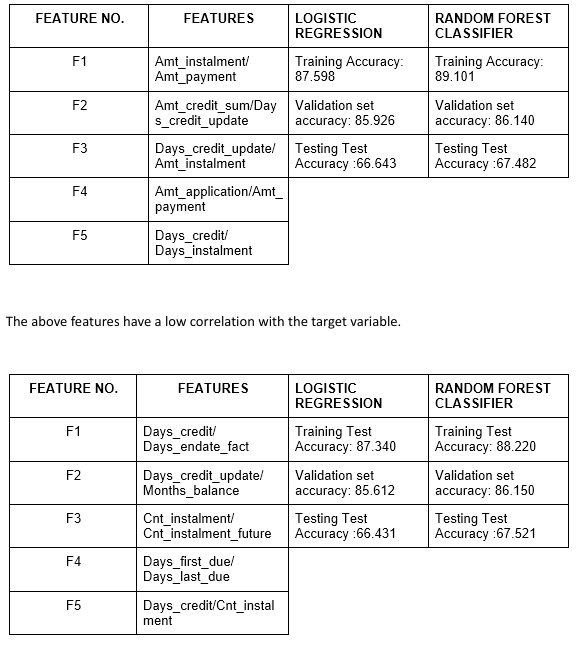

* Finally, these are the 8 new features we selected with their following accuracies :
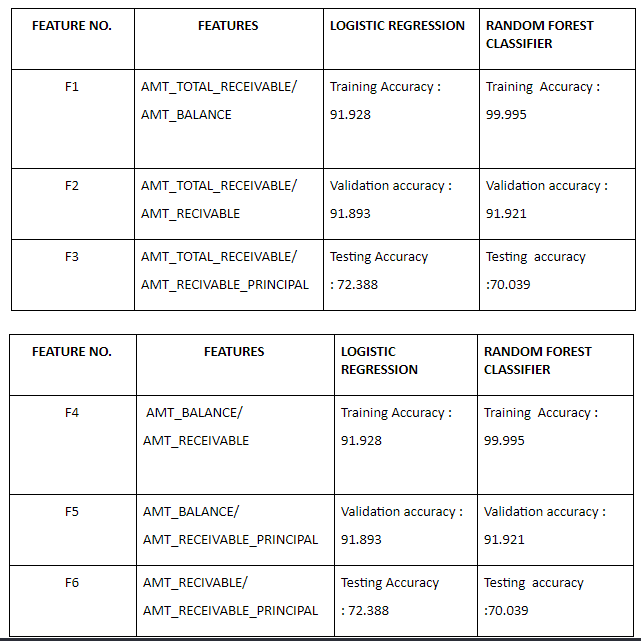

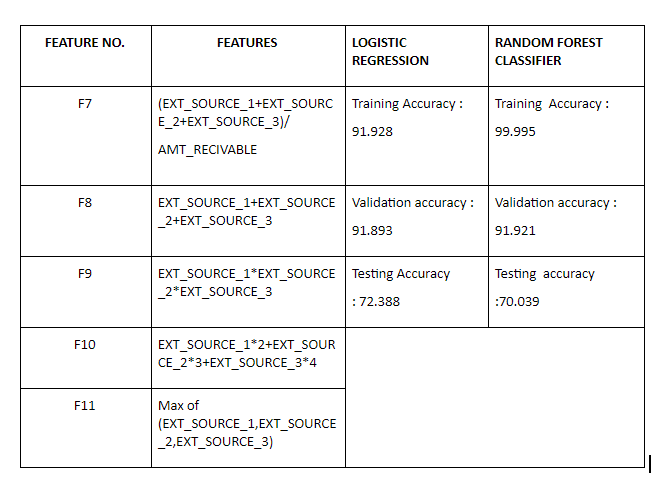

In [17]:
df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
df.describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,...,307511.000000,307511.000000,307511.000000,307511.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
mean,278180.518577,0.080729,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067,63815.045904,...,0.008130,0.000595,0.000507,0.000335,0.006402,0.007000,0.034362,0.267395,0.265474,1.899974
std,102790.175348,0.272419,0.722121,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,0.013831,4363.988632,141275.766519,...,0.089798,0.024387,0.022518,0.018299,0.083849,0.110757,0.204685,0.916002,0.794056,1.869295
min,100002.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-25229.000000,-17912.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189145.500000,0.000000,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,0.010006,-19682.000000,-2760.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,278202.000000,0.000000,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,0.018850,-15750.000000,-1213.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,367142.500000,0.000000,1.000000,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,0.028663,-12413.000000,-289.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,456255.000000,1.000000,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,0.072508,-7489.000000,365243.000000,...,1.000000,1.000000,1.000000,1.000000,4.000000,9.000000,8.000000,27.000000,261.000000,25.000000


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


In [20]:
df_test.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
df_test.describe()

,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,48744.000000,48744.000000,4.874400e+04,4.874400e+04,48720.000000,4.874400e+04,48744.000000,48744.000000,48744.000000,48744.000000,...,48744.000000,48744.0,48744.0,48744.0,42695.000000,42695.000000,42695.000000,42695.000000,42695.000000,42695.000000
mean,277796.676350,0.397054,1.784318e+05,5.167404e+05,29426.240209,4.626188e+05,0.021226,-16068.084605,67485.366322,-4967.652716,...,0.001559,0.0,0.0,0.0,0.002108,0.001803,0.002787,0.009299,0.546902,1.983769
std,103169.547296,0.709047,1.015226e+05,3.653970e+05,16016.368315,3.367102e+05,0.014428,4325.900393,144348.507136,3552.612035,...,0.039456,0.0,0.0,0.0,0.046373,0.046132,0.054037,0.110924,0.693305,1.838873
min,100001.000000,0.000000,2.694150e+04,4.500000e+04,2295.000000,4.500000e+04,0.000253,-25195.000000,-17463.000000,-23722.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,188557.750000,0.000000,1.125000e+05,2.606400e+05,17973.000000,2.250000e+05,0.010006,-19637.000000,-2910.000000,-7459.250000,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,277549.000000,0.000000,1.575000e+05,4.500000e+05,26199.000000,3.960000e+05,0.018850,-15785.000000,-1293.000000,-4490.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
75%,367555.500000,1.000000,2.250000e+05,6.750000e+05,37390.500000,6.300000e+05,0.028663,-12496.000000,-296.000000,-1901.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,3.000000
max,456250.000000,20.000000,4.410000e+06,2.245500e+06,180576.000000,2.245500e+06,0.072508,-7338.000000,365243.000000,0.000000,...,1.000000,0.0,0.0,0.0,2.000000,2.000000,2.000000,6.000000,7.000000,17.000000


In [22]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48744 entries, 0 to 48743
Columns: 121 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(40), object(16)
memory usage: 45.0+ MB


 **Declaring some functions**

In [23]:
def missing_per(df):
    missing_vals = df.isnull().sum(axis=0)*100/len(df)
    return missing_vals.sort_values(ascending=False)


In [24]:

def remove_cols(df,rem_cols):
    df.drop(columns = rem_cols,inplace=True)
    return df

In [25]:
# p = missing_per(df)
# cols_to_remove = p.reset_index()
# cols_to_remove.columns = ['col_name','flag']
# cols_to_remove_ = cols_to_remove[cols_to_remove['flag']>50]
# rem_cols = list(cols_to_remove_['col_name'])

In [26]:
def get_unique_in_a_column(df,n):
    u = []
    for cols in df.columns:
        if cols=='TARGET':
            continue
        u.append([cols,df[cols].nunique()])
    df_temp = pd.DataFrame(u,columns=['col_name','unique_values'])
    return pd.DataFrame(df_temp[df_temp['unique_values']<n])

In [27]:
def seg_num_cat(df_phase3):
    dfp3_numerical= df_phase3.select_dtypes(exclude='object')
    dfp3_numerical['TARGET'] = df_phase3['TARGET']
    dfp3_categorical= df.select_dtypes(include='object')
    return dfp3_numerical,dfp3_categorical

In [28]:
def zeros_df(df,per):
    dfp3_n0s = pd.DataFrame()
    columns = []
    percentage =[]
    for col in df.columns:
        if col == 'TARGET':
          continue
        count = (df[col] == 0).sum()
        columns.append(col)
        percentage.append(count/len(df[col]))
    dfp3_n0s['Column'] = columns
    dfp3_n0s['Percentage'] = percentage
    per = per/100
    dfp3_n0s = dfp3_n0s[dfp3_n0s['Percentage']>per]

    return dfp3_n0s
 

In [29]:
def to_consider_as_cat(df,thres_val):
    return list(get_unique_in_a_column(df,thres_val)['col_name'])

In [30]:
def corr_target(df,cor):
    cor_matrix = df.corr()['TARGET'].sort_values(key=abs,ascending=False).reset_index()
    cor_matrix.columns = ['col_name','Correlation']
    column_after_corr_filter = cor_matrix[abs(cor_matrix['Correlation'])>cor]
    return column_after_corr_filter

In [31]:
def missing(df,n):
    new_df = missing_per(df).reset_index()
    categ_ = []
    new_df.columns = ['index','flag']
    fin_df = []
    for row in new_df.itertuples():
        try:
          fin_df.append([row.index,row.flag,df[row.index].median(),df[row.index].mean(), df[row.index].nunique()])
        except:
          fin_df.append([row.index,row.flag,df[row.index].mode(),'NA',df[row.index].nunique()])
    cols = ['col_name','percentage_missing','median/Mode','mean','no_of_unique_values']
    temp = pd.DataFrame(fin_df,columns=cols)   
    return  temp[temp['percentage_missing']>n]






**Columns with more than 90% zero values in them**

In [32]:
more_than_90_zero = zeros_df(df,90)
more_than_90_zero

,Column,Percentage
26,FLAG_EMAIL,0.943280
33,REG_REGION_NOT_LIVE_REGION,0.984856
34,REG_REGION_NOT_WORK_REGION,0.949231
35,LIVE_REGION_NOT_WORK_REGION,0.959341
36,REG_CITY_NOT_LIVE_CITY,0.921827
93,DEF_60_CNT_SOCIAL_CIRCLE,0.912881
95,FLAG_DOCUMENT_2,0.999958
97,FLAG_DOCUMENT_4,0.999919
98,FLAG_DOCUMENT_5,0.984885
99,FLAG_DOCUMENT_6,0.911945


**Dropping the above columns from the dataset**

In [33]:
df.drop(columns = more_than_90_zero['Column'],inplace = True)

**Columns in training set having more than 30% of missing data, along with their median/mode and unique values in the column**

In [34]:
missing(df,30)

,col_name,percentage_missing,median/Mode,mean,no_of_unique_values
0,COMMONAREA_MEDI,69.872297,0.0208,0.044595,3202
1,COMMONAREA_MODE,69.872297,0.019,0.042553,3128
2,COMMONAREA_AVG,69.872297,0.0211,0.044621,3181
3,NONLIVINGAPARTMENTS_MEDI,69.432963,0.0,0.008651,214
4,NONLIVINGAPARTMENTS_AVG,69.432963,0.0,0.008809,386
5,NONLIVINGAPARTMENTS_MODE,69.432963,0.0,0.008076,167
6,FONDKAPREMONT_MODE,68.386172,0 reg oper account dtype: object,NA,4
7,LIVINGAPARTMENTS_MODE,68.354953,0.0771,0.105645,736
8,LIVINGAPARTMENTS_AVG,68.354953,0.0756,0.100775,1868
9,LIVINGAPARTMENTS_MEDI,68.354953,0.0761,0.101954,1097


**Segregating the Dataset in numerical and categorical dataframes**

In [35]:
df_num, df_cat = seg_num_cat(df)

C:\Users\12169\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [36]:
df_num.describe().T

,count,mean,std,min,25%,50%,75%,max
SK_ID_CURR,307511.0,278180.518577,102790.175348,100002.0,189145.5,278202.0,367142.5,456255.0
TARGET,307511.0,0.080729,0.272419,0.0,0.0,0.0,0.0,1.0
CNT_CHILDREN,307511.0,0.417052,0.722121,0.0,0.0,0.0,1.0,19.0
AMT_INCOME_TOTAL,307511.0,168797.919297,237123.146279,25650.0,112500.0,147150.0,202500.0,117000000.0
AMT_CREDIT,307511.0,599025.999706,402490.776996,45000.0,270000.0,513531.0,808650.0,4050000.0
...,...,...,...,...,...,...,...,...
AMT_REQ_CREDIT_BUREAU_DAY,265992.0,0.007000,0.110757,0.0,0.0,0.0,0.0,9.0
AMT_REQ_CREDIT_BUREAU_WEEK,265992.0,0.034362,0.204685,0.0,0.0,0.0,0.0,8.0
AMT_REQ_CREDIT_BUREAU_MON,265992.0,0.267395,0.916002,0.0,0.0,0.0,0.0,27.0
AMT_REQ_CREDIT_BUREAU_QRT,265992.0,0.265474,0.794056,0.0,0.0,0.0,0.0,261.0


In [37]:
df_cat.describe().T

,count,unique,top,freq
NAME_CONTRACT_TYPE,307511,2,Cash loans,278232
CODE_GENDER,307511,3,F,202448
FLAG_OWN_CAR,307511,2,N,202924
FLAG_OWN_REALTY,307511,2,Y,213312
NAME_TYPE_SUITE,306219,7,Unaccompanied,248526
NAME_INCOME_TYPE,307511,8,Working,158774
NAME_EDUCATION_TYPE,307511,5,Secondary / secondary special,218391
NAME_FAMILY_STATUS,307511,6,Married,196432
NAME_HOUSING_TYPE,307511,6,House / apartment,272868
OCCUPATION_TYPE,211120,18,Laborers,55186


**Numerical Columns and their correlation with the TARGET column in descending order**

In [38]:
corr_target(df_num,0.00)

,col_name,Correlation
0,TARGET,1.000000
1,EXT_SOURCE_3,-0.178919
2,EXT_SOURCE_2,-0.160472
3,EXT_SOURCE_1,-0.155317
4,DAYS_BIRTH,0.078239
...,...,...
76,NONLIVINGAPARTMENTS_MODE,-0.001557
77,AMT_REQ_CREDIT_BUREAU_HOUR,0.000930
78,AMT_REQ_CREDIT_BUREAU_WEEK,0.000788
79,FLAG_MOBIL,0.000534


**The Columns named "NAME_FAMILY_STATUS, CODE_GENDER, NAME_INCOME_TYPE"does not have values 'Unknown','XNA' and 'Maternity Leave' in the test dataset thus these rows are removed from the training dataset and there are a total of 11 rows that are removed.**

In [39]:
df =df[df['NAME_FAMILY_STATUS']!='Unknown']
df =df[df['CODE_GENDER']!='XNA']
df =df[df['NAME_INCOME_TYPE']!='Maternity leave']

**Considering Columns that have more than 2% correlation with the TARGET variable**

In [40]:
temp_df = corr_target(df_num,0.02)
# temp_df['SK_ID_CURR'] = df_num['SK_ID_CURR']
temp_df

,col_name,Correlation
0,TARGET,1.000000
1,EXT_SOURCE_3,-0.178919
2,EXT_SOURCE_2,-0.160472
3,EXT_SOURCE_1,-0.155317
4,DAYS_BIRTH,0.078239
5,REGION_RATING_CLIENT_W_CITY,0.060893
6,REGION_RATING_CLIENT,0.058899
7,DAYS_LAST_PHONE_CHANGE,0.055218
8,DAYS_ID_PUBLISH,0.051457
9,REG_CITY_NOT_WORK_CITY,0.050994


**Out of these columns we first need to deal with missing values of the columns. Thus we get all columns which have missing values**

In [41]:
temp_df_missing = missing(df[temp_df['col_name']],0)


Here in cols_with_no_missing we keep columns not having missing values

In [42]:
cols_with_no_missing = list(set(temp_df.col_name).difference(set(temp_df_missing.col_name)))


Setting a threshold of 10 for unique values in a column, if it is 10 or less we do not consider them as numerical but discrete and replace the missing values with the mode of the column

In [43]:
less_than_10 = temp_df_missing[temp_df_missing['no_of_unique_values']<=10]
temp_df_missing = temp_df_missing[temp_df_missing['no_of_unique_values']>10]

In [44]:
for i in less_than_10.col_name:
    df_num[i] = df_num[i].fillna(df_num[i].mode()[0])

for i in less_than_10.col_name:
    df_test[i] = df_test[i].fillna(df_test[i].mode()[0])

C:\Users\12169\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


**Finally, we get all the column names for the numerical columns that we will consider in our modeling and also imputation**

In [45]:
final_cols_in_num = list(less_than_10.col_name) + list(temp_df_missing.col_name) +cols_with_no_missing

**This gives us the final numerical dataframe**

In [46]:
df_num_temp = df_num
df_num = df_num[final_cols_in_num]
df_num.insert(0,"SK_ID_CURR",df_num_temp['SK_ID_CURR'])
df_num.head()

,SK_ID_CURR,DEF_30_CNT_SOCIAL_CIRCLE,LIVINGAPARTMENTS_MODE,LIVINGAPARTMENTS_MEDI,LIVINGAPARTMENTS_AVG,FLOORSMIN_MEDI,FLOORSMIN_AVG,FLOORSMIN_MODE,YEARS_BUILD_AVG,YEARS_BUILD_MEDI,...,REGION_POPULATION_RELATIVE,FLAG_DOCUMENT_3,DAYS_REGISTRATION,DAYS_EMPLOYED,DAYS_ID_PUBLISH,REGION_RATING_CLIENT_W_CITY,TARGET,REGION_RATING_CLIENT,HOUR_APPR_PROCESS_START,AMT_CREDIT
0,100002,2.0,0.022,0.0205,0.0202,0.1250,0.1250,0.1250,0.6192,0.6243,...,0.018801,1,-3648.0,-637,-2120,2,1,2,10,406597.5
1,100003,0.0,0.079,0.0787,0.0773,0.3333,0.3333,0.3333,0.7960,0.7987,...,0.003541,1,-1186.0,-1188,-291,1,0,1,11,1293502.5
2,100004,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.010032,0,-4260.0,-225,-2531,2,0,2,9,135000.0
3,100006,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.008019,1,-9833.0,-3039,-2437,2,0,2,17,312682.5
4,100007,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.028663,0,-4311.0,-3038,-3458,2,0,2,11,513000.0


**Here, we get the missing value of columns for the categorical columns, we see that out of 16 columns we get 6 columns that have missing values**

In [47]:
df_temp = missing(df_cat,0)
df_temp

,col_name,percentage_missing,median/Mode,mean,no_of_unique_values
0,FONDKAPREMONT_MODE,68.386172,0 reg oper account dtype: object,NA,4
1,WALLSMATERIAL_MODE,50.840783,0 Panel dtype: object,NA,7
2,HOUSETYPE_MODE,50.176091,0 block of flats dtype: object,NA,3
3,EMERGENCYSTATE_MODE,47.398304,0 No dtype: object,NA,2
4,OCCUPATION_TYPE,31.345545,0 Laborers dtype: object,NA,18
5,NAME_TYPE_SUITE,0.420148,0 Unaccompanied dtype: object,NA,7


**Getting the counts of each category in these columns**

**Here we observe that for columns :**

1)FONDKAPREMONT_MODE there is 68% missing data which makes it not ideal to impute missing values with the mode

2)WALLSMATERIAL_MODE, here the difference between the first and the second most occuring values is not much thus imputation with Mode is ambiguous

3)OCCUPATION_TYPE, this is a column that has 31% missing value and again there can not be one specific value that can be decided to impute the missing data with

Thus we remove these columns from the categorical part of the dataframe

In [48]:
cat_cols_to_rem = ['FONDKAPREMONT_MODE','WALLSMATERIAL_MODE','OCCUPATION_TYPE']


In [49]:
df_cat.drop(columns = cat_cols_to_rem,inplace=True)

C:\Users\12169\anaconda3\lib\site-packages\pandas\core\frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


**VISUAL EXPLORATORY DATA ANALYSIS**

**Visualizing the categorical columns to understand the data more efficiently**

In [50]:
def col(cat):
      plt.figure(figsize=(10,10))
      plt.title("Loan Default with respect to "+cat,fontweight='bold' , fontsize =16)
      sns.countplot(x=df[cat],hue='TARGET',data=df, palette = 'Blues')
      plt.xticks(rotation=90)

**How is the distribution of of loan according to gender?**


F      202448
M      105059
XNA         4
Name: CODE_GENDER, dtype: int64


Text(0.5, 1.0, 'Percentage of loan with reference to gender')

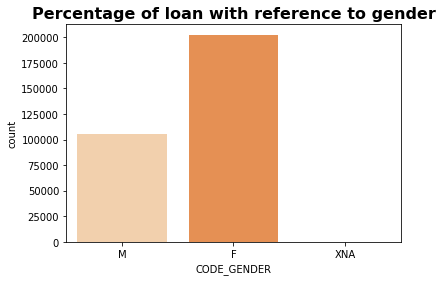

In [51]:
print(df_cat['CODE_GENDER'].value_counts())
sns.countplot(df_cat['CODE_GENDER'], palette = 'Oranges')
plt.title("Percentage of loan with reference to gender", fontweight = 'bold', fontsize = 16)

**Inference:** The number of female borrowing the loan and who haven't paid is comparatively higher than men. 

**What is the marital status of client?**

Married                 196432
Single / not married     45444
Civil marriage           29775
Separated                19770
Widow                    16088
Unknown                      2
Name: NAME_FAMILY_STATUS, dtype: int64


Text(0.5, 1.0, 'Family Status vs Count')

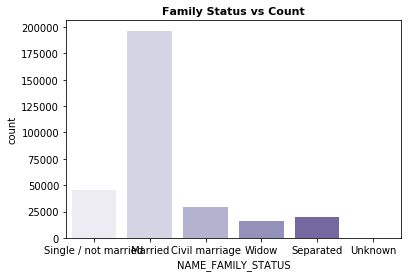

In [52]:
print(df_cat['NAME_FAMILY_STATUS'].value_counts())
sns.countplot(df_cat['NAME_FAMILY_STATUS'], palette = 'Purples')
plt.title("Family Status vs Count", fontweight = 'bold', fontsize = 11)

**Inference:** The majority of client who are Married have paid the least loan amount while the status of unknown is negligible.

**How many percent of client own a car?**

N    202924
Y    104587
Name: FLAG_OWN_CAR, dtype: int64


Text(0.5, 1.0, 'Percentage of car owners in the dataset')

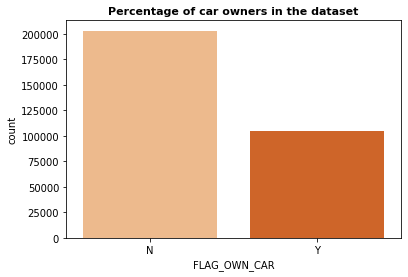

In [53]:
print(df_cat['FLAG_OWN_CAR'].value_counts())
sns.countplot(df_cat['FLAG_OWN_CAR'], palette = 'Oranges')
plt.title("Percentage of car owners in the dataset", fontweight = 'bold', fontsize = 11)

**Inference:** About 50 % of people own's a car, but there's majority of 
client (more than 50%) who doesn't possess a car and most of them are likely who haven't paid the loan.

**What type of educational background does the clients have?**

Secondary / secondary special    218391
Higher education                  74863
Incomplete higher                 10277
Lower secondary                    3816
Academic degree                     164
Name: NAME_EDUCATION_TYPE, dtype: int64


(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

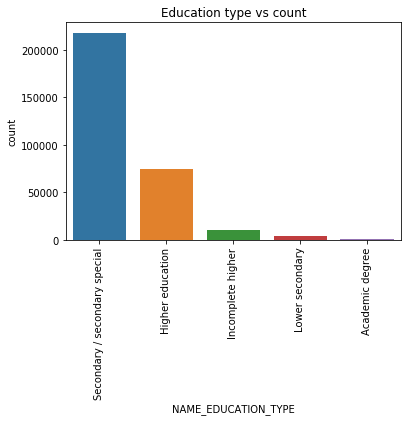

In [54]:
print(df_cat['NAME_EDUCATION_TYPE'].value_counts())
sns.countplot(df_cat['NAME_EDUCATION_TYPE'])
plt.title("Education type vs count")
plt.xticks(rotation=90)

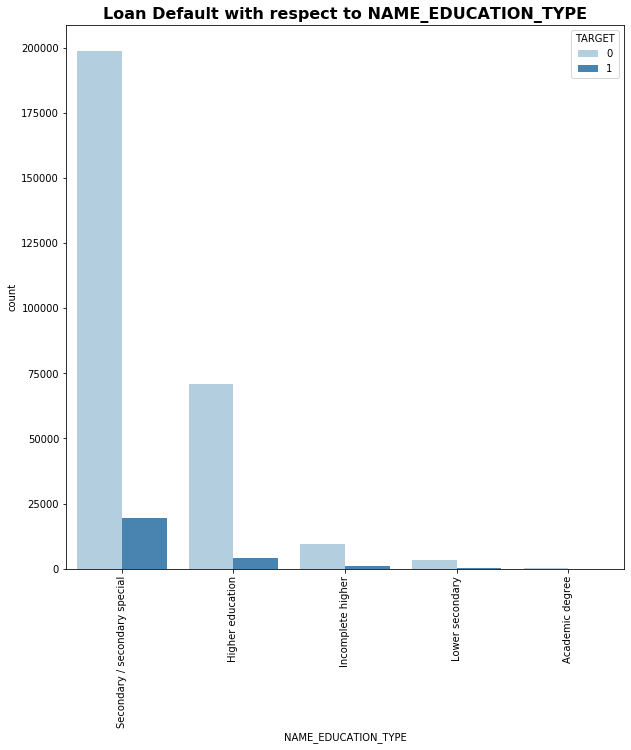

In [55]:
col('NAME_EDUCATION_TYPE')

**Inference:** Clients with Academic Degree are more likely to repay the loan compared to others.

**What are the types of housing does the clients stay in?**

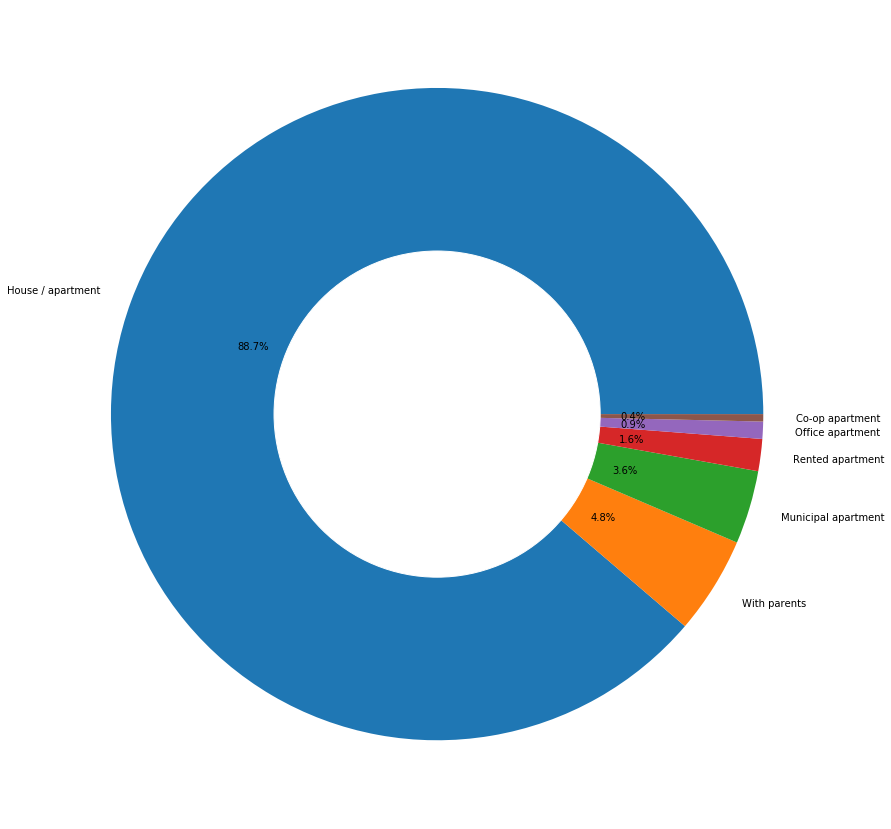

In [56]:
plt.figure(figsize=[20,15])
plt.pie(df_cat['NAME_HOUSING_TYPE'].value_counts(),labels = df_cat['NAME_HOUSING_TYPE'].value_counts().index,autopct='%1.1f%%')
my_circle=plt.Circle( (0,0), 0.5, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle)
# plt.title('Percentage of User Types')
plt.show()
#plt.ticks(rotation=90)

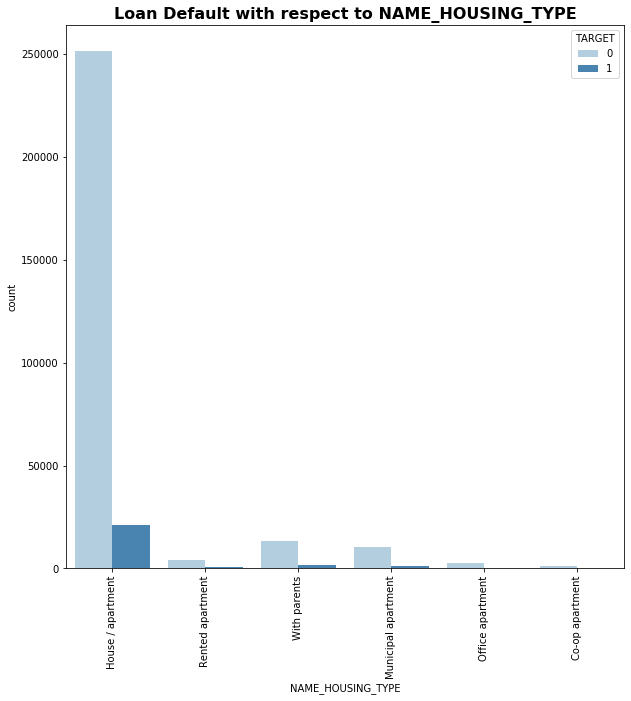

In [57]:
col("NAME_HOUSING_TYPE")

**Inference:** From the above graphical presentation, we can see that majority of the clients stay in apartment/House haven't paid the loan amount, while the least amount of them stay in office apartment and co-op apartment are negligible.

**What are income type of applicant in terms of loan does the clients have?**

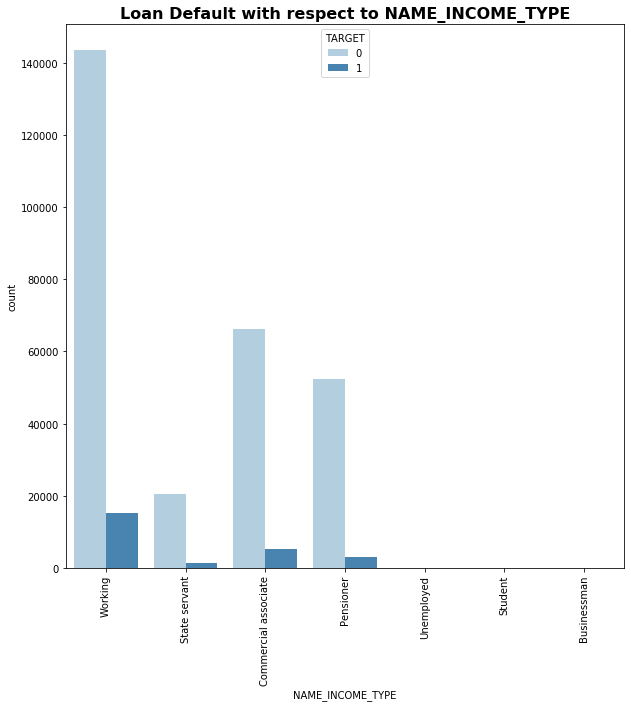

In [58]:
col("NAME_INCOME_TYPE")

**Inference:**
All the Students and Businessman are neglibile, here we can see that majority of working people are hardly paying the loan.

TUESDAY      53901
WEDNESDAY    51934
MONDAY       50714
THURSDAY     50591
FRIDAY       50338
SATURDAY     33852
SUNDAY       16181
Name: WEEKDAY_APPR_PROCESS_START, dtype: int64


Text(0.5, 1.0, 'Number of loan approval process vs day ')

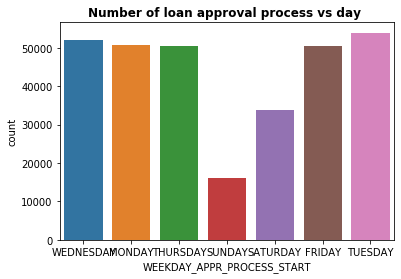

In [59]:
print(df_cat['WEEKDAY_APPR_PROCESS_START'].value_counts())
sns.countplot(df_cat['WEEKDAY_APPR_PROCESS_START'])
plt.title("Number of loan approval process vs day ", fontweight = 'bold', fontsize = 12)

**Inference:** 
The loan approval process has the highest count starting tuesday ,while the lowest count can be clearly seen on the weekends.

****What type of loan are available?****

Cash loans         278232
Revolving loans     29279
Name: NAME_CONTRACT_TYPE, dtype: int64


Text(0.5, 1.0, 'Types of loan available')

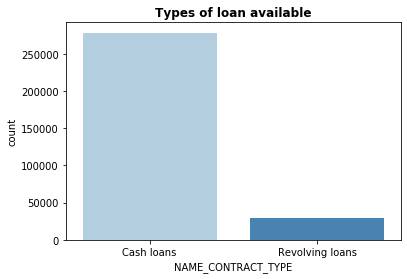

In [60]:
print(df_cat['NAME_CONTRACT_TYPE'].value_counts())
sns.countplot(df_cat['NAME_CONTRACT_TYPE'], palette = 'Blues')
plt.title("Types of loan available", fontweight = 'bold', fontsize = 12)

**Inference:** 
Many people are willing to take cash loan than revolving loan


**Here, we plot some graphs for the columns with highest correlations with the Target variable and observe the trend with respect to the target variable.**



Text(0.5, 1.0, 'EXT_SOURCE_3 vs TARGET')

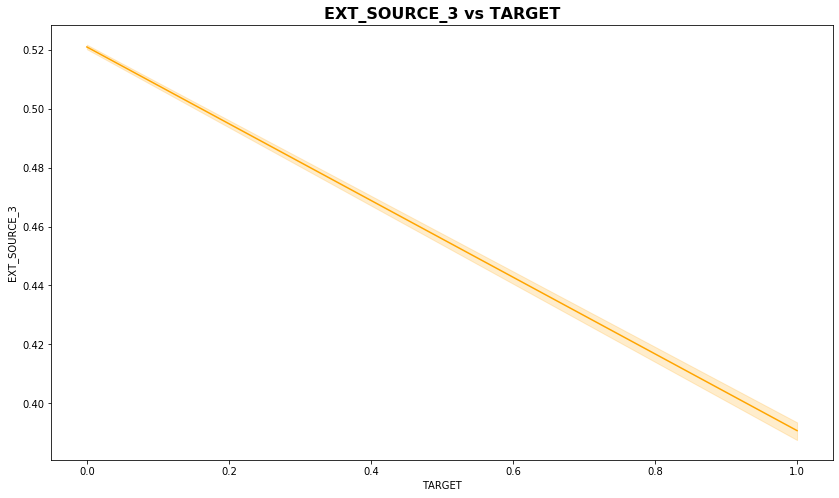

In [61]:
#Numerical Plot
plt.figure(figsize=[14,8])
sns.lineplot(x='TARGET',y='EXT_SOURCE_3',data=df,color= 'orange')
plt.title("EXT_SOURCE_3 vs TARGET", fontweight = 'bold', fontsize = 16)

Text(0.5, 1.0, 'EXT_SOURCE_2 vs TARGET')

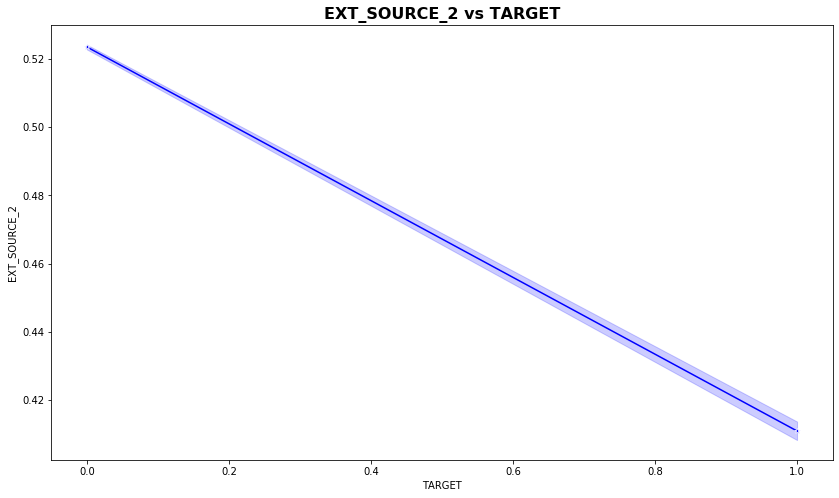

In [62]:
plt.figure(figsize=[14,8])
sns.lineplot(x='TARGET',y='EXT_SOURCE_2',data=df,marker='*',color= 'blue')
plt.title("EXT_SOURCE_2 vs TARGET", fontweight = 'bold', fontsize = 16)

Text(0.5, 1.0, 'EXT_SOURCE_1 vs TARGET')

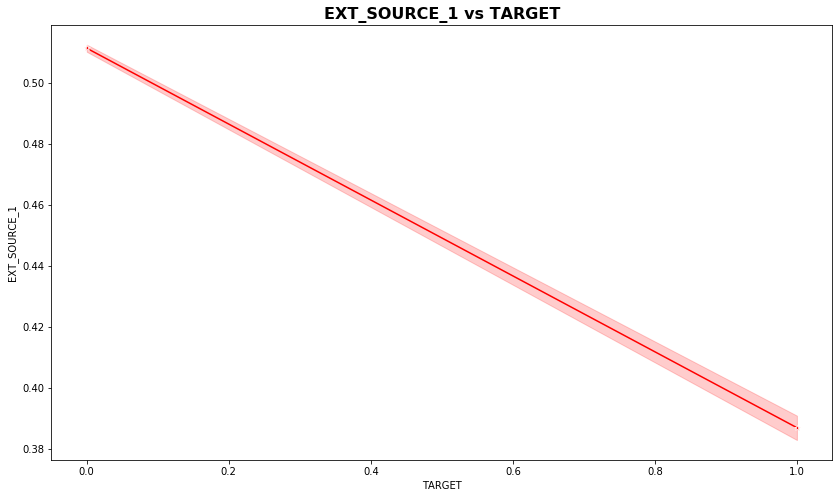

In [63]:
plt.figure(figsize=[14,8])
sns.lineplot(x='TARGET',y='EXT_SOURCE_1',data=df,marker='*',color= 'red')
plt.title("EXT_SOURCE_1 vs TARGET", fontweight = 'bold', fontsize = 16)

**Inference:**We see these for the columns EXT_SOURCE_3, EXT_SOURCE_2 and EXT_SOURCE_1 and can observe a clear strong negative correlation

**What type of correlation does the columns DAYS_BIRTH and DAY_LAST_PHONE_CHANGE have with respect to target?**







Text(0.5, 1.0, 'DAYS_BIRTH vs TARGET')

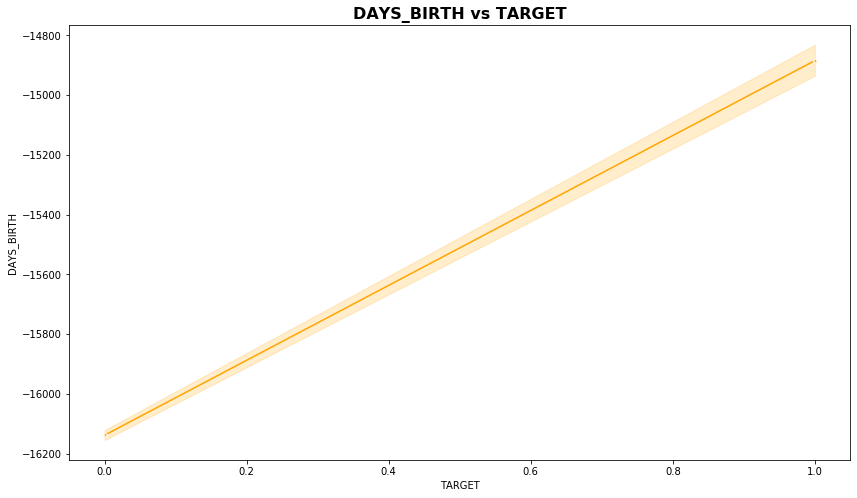

In [64]:
plt.figure(figsize=[14,8])
sns.lineplot(x='TARGET',y='DAYS_BIRTH',data=df,marker='*',color= 'orange')
plt.title("DAYS_BIRTH vs TARGET", fontweight = 'bold', fontsize = 16)

Text(0.5, 1.0, 'DAYS_LAST_PHONE_CHANGE vs TARGET')

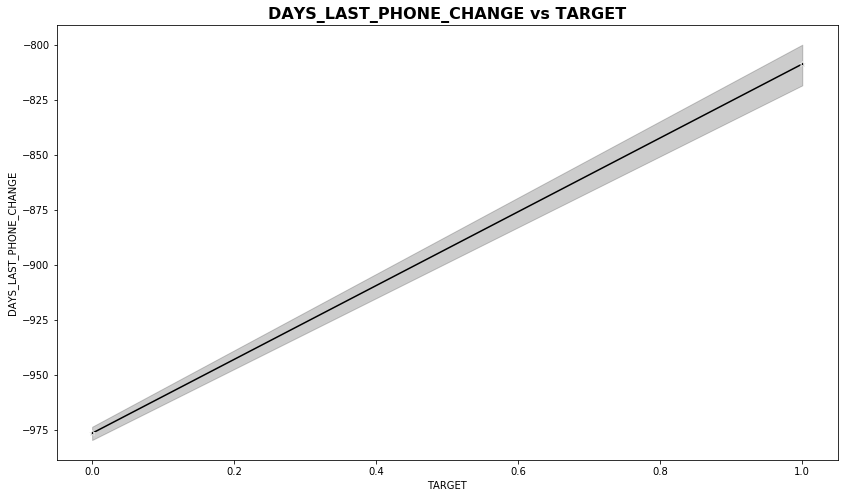

In [65]:
plt.figure(figsize=[14,8])
sns.lineplot(x='TARGET',y='DAYS_LAST_PHONE_CHANGE',data=df,marker='*',color= 'black')
plt.title("DAYS_LAST_PHONE_CHANGE vs TARGET", fontweight = 'bold', fontsize = 16)

**Inference:** From the above plots,we can see that for columns of DAYS_BIRTH and DAYS_LAST_PHONE_CHANGE we see a strong positive correlation with respect to the target.

# **MODELING PIPELINES**

In this project, we are creating three pipelines, one for numerical data, one for categorical data and finally a pipeline to combine the data. 

(i).Numerical data pipeline:
For the pipeline with numerical data also called ‘num_pipeline’, we impute the missing values by the mean of the columns.

(ii). Categorical data pipeline:
For the pipeline with categorical data also called ‘cat_pipeline’, we impute the missing values by the mode or the most frequent data.

(iii)Final pipeline:
We create a pipeline to merge the numerical and categorical columns that have no missing values. The categorical columns are also one hot encoded.



Importing necessary packages

In [66]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [67]:
df_num.shape

(307511, 48)

**Finally selecting only the columns that we have finally decided for the numerical and the categorical part**

In [68]:
# df_num.drop(columns = ['TARGET'],inplace=True)
df_cols = list(df_num.columns)+ list(df_cat.columns)

In [69]:
df_i = df[df_cols]

**Making two pipelines one for the numerical data where we impute the missing values by the mean of the columns, and the other for categorical data where we impute the missing data in the categorical columns using the Mode or the most frequent data.**

In [70]:
num_pipeline = Pipeline(steps=[('imputer', SimpleImputer(strategy='mean'))])

cat_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('ohe', OneHotEncoder(sparse=False, handle_unknown="ignore"))
    ])

**Here we create a pipeline to merge the numerical and categorical columns that have no missing values and the categorical columns are one hot encoded.**

In [71]:
data_pipeline = ColumnTransformer([
    ("num_pipeline", num_pipeline, df_num.columns),
    ("cat_pipeline", cat_pipeline, df_cat.columns)], n_jobs = -1)
df_transformed = data_pipeline.fit_transform(df_i)
column_names = list(df_num.columns)  + \
               list(data_pipeline.transformers_[1][1].named_steps["ohe"].get_feature_names(df_cat.columns))

C:\Users\12169\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


**This is the final dataset that we get for training our model**

In [72]:
df_n = pd.DataFrame(df_transformed,  columns=column_names)

In [73]:
# df_n = pd.read_csv('bhai_appl_train_bhai.csv')

In [74]:
# df_n.drop(columns=['Unnamed: 0'],inplace=True)

In [75]:
df_n.head()

,SK_ID_CURR,DEF_30_CNT_SOCIAL_CIRCLE,LIVINGAPARTMENTS_MODE,LIVINGAPARTMENTS_MEDI,LIVINGAPARTMENTS_AVG,FLOORSMIN_MEDI,FLOORSMIN_AVG,FLOORSMIN_MODE,YEARS_BUILD_AVG,YEARS_BUILD_MEDI,...,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA,HOUSETYPE_MODE_block of flats,HOUSETYPE_MODE_specific housing,HOUSETYPE_MODE_terraced house,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes
0,100002.0,2.0,0.022000,0.020500,0.020200,0.125000,0.125000,0.12500,0.619200,0.624300,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,100003.0,0.0,0.079000,0.078700,0.077300,0.333300,0.333300,0.33330,0.796000,0.798700,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,100004.0,0.0,0.105646,0.101956,0.100776,0.231626,0.231895,0.22806,0.752469,0.755744,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,100006.0,0.0,0.105646,0.101956,0.100776,0.231626,0.231895,0.22806,0.752469,0.755744,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,100007.0,0.0,0.105646,0.101956,0.100776,0.231626,0.231895,0.22806,0.752469,0.755744,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [76]:
df_temp = df_n

In [77]:
df_n = pd.merge(left=df_n, right=df_inst, how='left', left_on='SK_ID_CURR', right_on='SK_ID_CURR')

In [78]:
df_n = pd.merge(left=df_n, right=df_pos_c_bal, how='left', left_on='SK_ID_CURR', right_on='SK_ID_CURR')

In [79]:
df_n = pd.merge(left=df_n, right=df_prev_app, how='left', left_on='SK_ID_CURR', right_on='SK_ID_CURR')

In [80]:
df_n = pd.merge(left=df_n, right=credit_card_bal, how='left', left_on='SK_ID_CURR', right_on='SK_ID_CURR')

C:\Users\12169\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Passing 'suffixes' which cause duplicate columns {'SK_ID_PREV_x'} in the result is deprecated and will raise a MergeError in a future version.
  """Entry point for launching an IPython kernel.


In [81]:
df_n = pd.merge(left=df_n, right=new_bb, how='left', left_on='SK_ID_CURR', right_on='SK_ID_CURR')

In [82]:
df_final_app_imputer = df_n

In [83]:
df_final_app_imputer['FEATURE1']= df_final_app_imputer['AMT_TOTAL_RECEIVABLE']/(df_final_app_imputer['AMT_BALANCE']+1)
df_final_app_imputer['FEATURE2'] = df_final_app_imputer['AMT_TOTAL_RECEIVABLE']/(df_final_app_imputer['AMT_RECIVABLE']+1)
df_final_app_imputer['FEATURE3'] = df_final_app_imputer['AMT_TOTAL_RECEIVABLE']/(df_final_app_imputer['AMT_RECEIVABLE_PRINCIPAL']+1)


df_final_app_imputer['FEATURE4']=df_final_app_imputer['AMT_BALANCE']/(df_final_app_imputer['AMT_RECIVABLE']+1)
df_final_app_imputer['FEATURE5']=df_final_app_imputer['AMT_BALANCE']/(df_final_app_imputer['AMT_RECEIVABLE_PRINCIPAL']+1)
df_final_app_imputer['FEATURE6']=df_final_app_imputer['AMT_RECIVABLE']/(df_final_app_imputer['AMT_RECEIVABLE_PRINCIPAL']+1)
df_final_app_imputer['FEATURE7']=(df_final_app_imputer['EXT_SOURCE_1']+df_final_app_imputer['EXT_SOURCE_2']+df_final_app_imputer['EXT_SOURCE_3'])/(df_final_app_imputer['AMT_TOTAL_RECEIVABLE']+1)

df_final_app_imputer['FEATURE8']=(df_final_app_imputer['EXT_SOURCE_1']+df_final_app_imputer['EXT_SOURCE_2']+df_final_app_imputer['EXT_SOURCE_3'])

In [84]:
df_final_app_imputer['FEATURE9']=(df_final_app_imputer['EXT_SOURCE_1']*df_final_app_imputer['EXT_SOURCE_2']*df_final_app_imputer['EXT_SOURCE_3'])

df_final_app_imputer['FEATURE10'] =  (df_final_app_imputer['EXT_SOURCE_1']*2+df_final_app_imputer['EXT_SOURCE_2']*3+df_final_app_imputer['EXT_SOURCE_3']*4)

df_final_app_imputer['FEATURE11'] = [max(ele1,ele2,ele3) for ele1, ele2, ele3 in zip(df_final_app_imputer['EXT_SOURCE_1'], df_final_app_imputer['EXT_SOURCE_2'], df_final_app_imputer['EXT_SOURCE_3'])]

In [85]:
df_final_app_imputer.shape
correlation=corr_target(df_final_app_imputer[['FEATURE1','FEATURE2','FEATURE3','FEATURE4','FEATURE5','FEATURE6','FEATURE7','FEATURE8','FEATURE9','FEATURE10','FEATURE11','TARGET']],0.0)

In [86]:
correlation

,col_name,Correlation
0,TARGET,1.000000
1,FEATURE10,-0.223086
2,FEATURE8,-0.221463
3,FEATURE9,-0.189587
4,FEATURE11,-0.175531
5,FEATURE7,-0.127584
6,FEATURE2,0.097301
7,FEATURE1,-0.000773
8,FEATURE6,0.000493
9,FEATURE3,0.000396


In [87]:
df_final_app_imputer['TARGET'].head()

0    1.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: TARGET, dtype: float64

1)Amt credit/Amt annuity,
 2)Amt installment /Amt credit, 
3)Day_first_due - Day_last_due,
4)Amt application/Amt payment
5)Amt credit sum/amt credit
6)Amt installment /Days installment
7))Amt credit sum/days credit

In [88]:
df_final_app_imputer = df_final_app_imputer.rename(columns = {'AMT_CREDIT_y':'AMT_CREDIT'})

In [89]:
df_final_app_imputer = df_final_app_imputer.apply(lambda x: x.fillna(x.median()),axis=0)

#### Including features only with 5% and above correlation

In [90]:
five_percent_se_jyada = corr_target(df_final_app_imputer,0.05)

In [91]:
five_percent_se_jyada = five_percent_se_jyada['col_name'][1:]

### RESULTS AND DISCUSSION OF RESULTS

In [92]:
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [93]:
models_results = []
Target = df_final_app_imputer['TARGET']
df_temp_5_percent = df_final_app_imputer[five_percent_se_jyada]

In [94]:
df_temp_5_percent.columns

Index(['FEATURE10', 'FEATURE8', 'FEATURE9', 'FEATURE11', 'EXT_SOURCE_2',
       'EXT_SOURCE_3', 'EXT_SOURCE_1', 'DAYS_CREDIT', 'DAYS_BIRTH', 'FEATURE7',
       'DAYS_CREDIT_UPDATE', 'REGION_RATING_CLIENT_W_CITY',
       'REGION_RATING_CLIENT', 'NAME_INCOME_TYPE_Working',
       'NAME_EDUCATION_TYPE_Higher education', 'DAYS_LAST_PHONE_CHANGE',
       'CODE_GENDER_M', 'CODE_GENDER_F', 'DAYS_ID_PUBLISH',
       'REG_CITY_NOT_WORK_CITY', 'FEATURE2'],
      dtype='object')

In [95]:
X = df_temp_5_percent.values
y = Target.values

In [96]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.15, random_state=42)

Here I will be using the lbfgs solver which is a Limited-memory BFGS (L-BFGS or LM-BFGS) optimization algorithm in the family of quasi-Newton methods that approximates the Broyden–Fletcher–Goldfarb–Shanno algorithm (BFGS) using a limited amount of computer memory

Logistic Regression

**Hyperparameter tuning**

* After selecting the optimal features for our models, we use hyperparameter tuning to find the most optimal setting for running our model.
* For hyperparameter tuning, we have decided to use GridSearchCV. The GridSearchCV is a library of sklearn’s model selection package. It helps to fit our model on our data by using the best running conditions and the best parameters possible.
* By just specifying the model, input parameters, and accuracy we want, we can easily obtain the best running conditions and features using GridSearchCV.
* In our code, for logistic regression, we have created a function for GridSearchCV with 3 cross-validations for the hyperparameters and 1000 max iterations.

In [97]:
pipe = Pipeline([
('scaler', StandardScaler()),
('classifier', GridSearchCV(LogisticRegression(solver='lbfgs', max_iter=1000),
                                 param_grid={'C': [ 0.1,1,5,10.]},
                                 cv=5,
                                 refit=True))
])
pipe.fit(X_train, y_train)


Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier',
                 GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000),
                              param_grid={'C': [0.1, 1, 5, 10.0]}))])

In [98]:
pipe.named_steps['classifier'].best_params_

{'C': 0.1}

In [99]:
print('Training set accuracy score: ' + str(pipe.score(X_train,y_train)))
y_pred = pipe.predict(X_valid)
print('Validation set accuracy score: ' + str(accuracy_score(y_valid,y_pred)))
print('Log loss: ',log_loss(y_valid,y_pred))
print('Confusion Matrix: ','\n',confusion_matrix(y_valid, y_pred))
print('ROC_AUC: ',roc_auc_score(y_valid, pipe.predict_proba(X_valid)[:, 1]))

Training set accuracy score: 0.9192883787661406
Validation set accuracy score: 0.9189376693766937
Log loss:  2.79979385013226
Confusion Matrix:  
 [[42372     8]
 [ 3731    14]]
ROC_AUC:  0.7293817901609885


In [100]:
models_results.append(['Logistic Regression',pipe.score(X_train,y_train),accuracy_score(y_valid,y_pred)])

C:\Users\12169\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


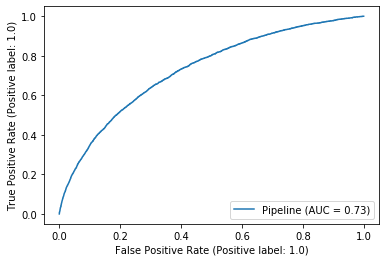

In [101]:
metrics.plot_roc_curve(pipe, X_valid, y_valid)

RandomForestClassifer

In [102]:
# param_grid = { 
#     'n_estimators': [200, 500],
#     'max_features': ['auto', 'sqrt', 'log2'],
#     'max_depth' : [4,5,6,7,8],
#     'criterion' :['gini', 'entropy']
# }

param_grid = { 
    'n_estimators': [40,50,60],
    'max_features': ['auto'],
    'max_depth' : [15,20,25],
    'criterion' :['entropy']
}


In [103]:
pipe1 = Pipeline([
('scaler', StandardScaler()),
('classifier', GridSearchCV(RandomForestClassifier(),
                                 param_grid=param_grid,
                                 cv=4,
                                 refit=True))
])
pipe1.fit(X_train, y_train)


Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier',
                 GridSearchCV(cv=4, estimator=RandomForestClassifier(),
                              param_grid={'criterion': ['entropy'],
                                          'max_depth': [15, 20, 25],
                                          'max_features': ['auto'],
                                          'n_estimators': [40, 50, 60]}))])

In [104]:
pipe1.named_steps['classifier'].best_params_

{'criterion': 'entropy',
 'max_depth': 15,
 'max_features': 'auto',
 'n_estimators': 50}

In [105]:
print('Training set accuracy score: ' + str(pipe1.score(X_train,y_train)))
y_pred = pipe1.predict(X_valid)
print('Validation set accuracy score: ' + str(accuracy_score(y_valid,y_pred)))
print('Log loss: ',log_loss(y_valid,y_pred))
print('Confusion Matrix: ','\n',confusion_matrix(y_valid, y_pred))
print('ROC_AUC: ',roc_auc_score(y_valid, pipe1.predict_proba(X_valid)[:, 1]))

Training set accuracy score: 0.9239292204686753
Validation set accuracy score: 0.9192845528455285
Log loss:  2.7878131969342186
Confusion Matrix:  
 [[42356    24]
 [ 3699    46]]
ROC_AUC:  0.7306289146894618


C:\Users\12169\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


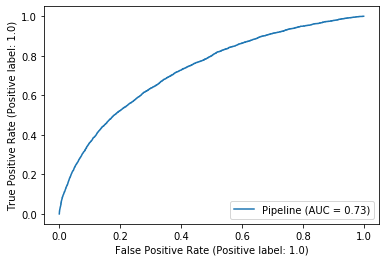

In [106]:
metrics.plot_roc_curve(pipe1, X_valid, y_valid)

In [107]:
models_results.append(['Random Regression Classifier',pipe1.score(X_train,y_train),accuracy_score(y_valid,y_pred)])

In [108]:
pd.DataFrame(models_results,columns = ['Model Name', 'Training Accuracy', 'Validation Accuracy'])

,Model Name,Training Accuracy,Validation Accuracy
0,Logistic Regression,0.919288,0.918938
1,Random Regression Classifier,0.923929,0.919285


#### Pipeline

In [112]:
pipe_lr = Pipeline([
('scaler', StandardScaler()),
('classifier', LogisticRegression(solver='lbfgs', max_iter=1000))
])
 
pipe_lr.fit(X_train, y_train)


Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier', LogisticRegression(max_iter=1000))])

In [113]:

print('Training set accuracy score: ' + str(pipe_lr.score(X_train,y_train)))
y_pred = pipe_lr.predict(X_valid)
print('Validation set accuracy score: ' + str(accuracy_score(y_valid,y_pred)))
print('Log loss: ',log_loss(y_valid,y_pred))
print('Confusion Matrix: ','\n',confusion_matrix(y_valid, y_pred))
print('ROC_AUC: ',roc_auc_score(y_valid, pipe_lr.predict_proba(X_valid)[:, 1]))

Training set accuracy score: 0.9192883787661406
Validation set accuracy score: 0.9189376693766937
Log loss:  2.79979385013226
Confusion Matrix:  
 [[42372     8]
 [ 3731    14]]
ROC_AUC:  0.7293757163082316


In [114]:
models_results.append(['Logistic Regression',pipe_lr.score(X_train,y_train),accuracy_score(y_valid,y_pred)])

C:\Users\12169\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


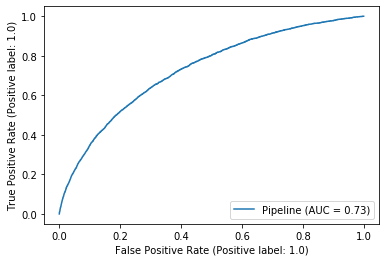

In [115]:
metrics.plot_roc_curve(pipe_lr, X_valid, y_valid)

In [116]:
pipe_rf = Pipeline([
('scaler', StandardScaler()),
('classifier', RandomForestClassifier())
])
 
pipe_rf.fit(X_train, y_train)


Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier', RandomForestClassifier())])

In [117]:
 print('Training set accuracy score: ' + str(pipe_rf.score(X_train,y_train)))
y_pred = pipe_rf.predict(X_valid)
print('Validation set accuracy score: ' + str(accuracy_score(y_valid,y_pred)))
print('Log loss: ',log_loss(y_valid,y_pred))
print('Confusion Matrix: ','\n',confusion_matrix(y_valid, y_pred))
print('ROC_AUC: ',roc_auc_score(y_valid, pipe_rf.predict_proba(X_valid)[:, 1]))

Training set accuracy score: 0.9999273075083692
Validation set accuracy score: 0.9189376693766937
Log loss:  2.799794872923553
Confusion Matrix:  
 [[42313    67]
 [ 3672    73]]
ROC_AUC:  0.7085823696972713


In [118]:
models_results.append(['Random Forest Classifier',pipe_rf.score(X_train,y_train),accuracy_score(y_valid,y_pred)])

C:\Users\12169\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


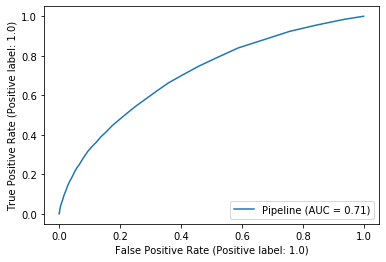

In [119]:
metrics.plot_roc_curve(pipe_rf, X_valid, y_valid)

In [120]:
pd.DataFrame(models_results,columns = ['Model Name', 'Training Accuracy', 'Validation Accuracy'])

,Model Name,Training Accuracy,Validation Accuracy
0,Logistic Regression,0.919288,0.918938
1,Random Regression Classifier,0.923929,0.919285
2,Logistic Regression,0.919288,0.918938
3,Random Forest Classifier,0.999927,0.918938


- Here we can see that Random Forest Classifier has the best training accuracy of around 99% but an accuracy like this runs a risk of overfitting. 
- The logistic Regression Model also gives an accuracy of 91% which is descent enough and seems to be a consdierable model.
- The ROC Area Under Curve value for Random Forest Classifier and the Logistic regression models are 0.704 and 0.735 respectively and both of them show a significant amount of True Positive values which shows that this is a good model fit. 
- We cannot consider Naive Bayes as our model as it is evidently underfitting the data. 
- We need to check how Random Forest classifier and the Logistic Regression model works on the test data to confirm if Random forest is really overfitting.

**For Kaggle submission**

In [126]:
X = df_temp_5_percent.values
y = df['TARGET'].values

In the following pipeline I have used standard scaler to normalize the data with mean being zero and the standard deviation being 1, and use Logistic Regression as our modeling algorithm with solver being lbfgs and interations for convergence being 1000

In [129]:
pipe = Pipeline([
('scaler', StandardScaler()),
('classifier', LogisticRegression(solver='lbfgs', max_iter=1000))
])
 
pipe.fit(X, y)
 
print('Training set score: ' + str(pipe.score(X,y)))


Training set score: 0.9192357723577236


In [130]:
pipe_rf = Pipeline([
('scaler', StandardScaler()),
('classifier', RandomForestClassifier())
])
 
pipe_rf.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier', RandomForestClassifier())])

In [131]:
print('Training set score: ' + str(pipe_rf.score(X_train,y_train)))

Training set score: 0.9999579148732664


## Test Dataset

Here we get the same final columns as for the training dataset in the test dataset

In [132]:
df_cols = list(df_num.columns)+ list(df_cat.columns)

In [137]:
df_cols.remove('TARGET')

In [138]:
'TARGET' in df_cols

False

In [139]:
df_test_n= df_test[df_cols]

In [140]:
num_pipeline1 = Pipeline(steps=[('imputer', SimpleImputer(strategy='mean'))])
cat_pipeline1 = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('ohe', OneHotEncoder(sparse=False, handle_unknown="ignore"))
    ])

In [141]:
df_test_n_num = df_test_n.select_dtypes(exclude='object')
df_test_n_cat = df_test_n.select_dtypes(include='object')

In [142]:
data_pipeline1 = ColumnTransformer([
    ("num_pipeline", num_pipeline1, df_test_n_num.columns),
    ("cat_pipeline", cat_pipeline1, df_test_n_cat.columns)], n_jobs = -1)
df_transformed1 = data_pipeline1.fit_transform(df_test_n)
column_names = list(df_test_n_num.columns)  + \
               list(data_pipeline1.transformers_[1][1].named_steps["ohe"].get_feature_names(df_test_n_cat.columns))

C:\Users\12169\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [143]:
df_n_test = pd.DataFrame(df_transformed1,  columns=column_names)

In [144]:
df_n_test = pd.merge(left=df_n_test, right=df_pos_c_bal, how='left', left_on='SK_ID_CURR', right_on='SK_ID_CURR')
df_n_test = pd.merge(left=df_n_test, right=df_prev_app, how='left', left_on='SK_ID_CURR', right_on='SK_ID_CURR')
df_n_test = pd.merge(left=df_n_test, right=credit_card_bal, how='left', left_on='SK_ID_CURR', right_on='SK_ID_CURR')
df_n_test = pd.merge(left=df_n_test, right=new_bb, how='left', left_on='SK_ID_CURR', right_on='SK_ID_CURR')
df_n_test = pd.merge(left=df_n_test, right=df_inst, how='left', left_on='SK_ID_CURR', right_on='SK_ID_CURR')


C:\Users\12169\anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Passing 'suffixes' which cause duplicate columns {'SK_ID_PREV_x'} in the result is deprecated and will raise a MergeError in a future version.
  """


In [145]:
df_n_test['FEATURE1']= df_n_test['AMT_TOTAL_RECEIVABLE']/(df_n_test['AMT_BALANCE']+1)
df_n_test['FEATURE2'] = df_n_test['AMT_TOTAL_RECEIVABLE']/(df_n_test['AMT_RECIVABLE']+1)
df_n_test['FEATURE3'] = df_n_test['AMT_TOTAL_RECEIVABLE']/(df_n_test['AMT_RECEIVABLE_PRINCIPAL']+1)


df_n_test['FEATURE4']=df_n_test['AMT_BALANCE']/(df_n_test['AMT_RECIVABLE']+1)
df_n_test['FEATURE5']=df_n_test['AMT_BALANCE']/(df_n_test['AMT_RECEIVABLE_PRINCIPAL']+1)
df_n_test['FEATURE6']=df_n_test['AMT_RECIVABLE']/(df_n_test['AMT_RECEIVABLE_PRINCIPAL']+1)
df_n_test['FEATURE7']=(df_n_test['EXT_SOURCE_1']+df_n_test['EXT_SOURCE_2']+df_n_test['EXT_SOURCE_3'])/(df_n_test['AMT_TOTAL_RECEIVABLE']+1)

df_n_test['FEATURE8']=(df_n_test['EXT_SOURCE_1']+df_n_test['EXT_SOURCE_2']+df_n_test['EXT_SOURCE_3'])

In [146]:
df_n_test['FEATURE9']=(df_n_test['EXT_SOURCE_1']*df_n_test['EXT_SOURCE_2']*df_n_test['EXT_SOURCE_3'])

df_n_test['FEATURE10'] =  (df_n_test['EXT_SOURCE_1']*2+df_n_test['EXT_SOURCE_2']*3+df_n_test['EXT_SOURCE_3']*4)

df_n_test['FEATURE11'] = [max(ele1,ele2,ele3) for ele1, ele2, ele3 in zip(df_n_test['EXT_SOURCE_1'], df_n_test['EXT_SOURCE_2'], df_n_test['EXT_SOURCE_3'])]

In [147]:
df_n_test.head()

,SK_ID_CURR,DEF_30_CNT_SOCIAL_CIRCLE,LIVINGAPARTMENTS_MODE,LIVINGAPARTMENTS_MEDI,LIVINGAPARTMENTS_AVG,FLOORSMIN_MEDI,FLOORSMIN_AVG,FLOORSMIN_MODE,YEARS_BUILD_AVG,YEARS_BUILD_MEDI,...,FEATURE2,FEATURE3,FEATURE4,FEATURE5,FEATURE6,FEATURE7,FEATURE8,FEATURE9,FEATURE10,FEATURE11
0,100001.0,0.0,0.110874,0.107063,0.105885,0.237846,0.238423,0.233854,0.751137,0.754344,...,NaN,NaN,NaN,NaN,NaN,NaN,1.701788,0.094803,4.512270,0.789654
1,100005.0,0.0,0.110874,0.107063,0.105885,0.237846,0.238423,0.233854,0.751137,0.754344,...,NaN,NaN,NaN,NaN,NaN,NaN,1.289607,0.071345,3.736794,0.564990
2,100013.0,0.0,0.110874,0.107063,0.105885,0.237846,0.238423,0.233854,0.751137,0.754344,...,0.000000,0.000,0.00000,0.00000,0.000,1.811958,1.811958,0.214286,5.545685,0.699787
3,100028.0,0.0,0.262600,0.244600,0.240400,0.041700,0.041700,0.041700,0.959200,0.959700,...,0.999863,1.083,1.01627,1.10077,1.083,0.000225,1.648115,0.164177,5.031316,0.612704
4,100038.0,0.0,0.110874,0.107063,0.105885,0.237846,0.238423,0.233854,0.751137,0.754344,...,NaN,NaN,NaN,NaN,NaN,NaN,1.127938,0.043034,3.681774,0.500106


In [148]:
df_n_test.rename(columns={'AMT_CREDIT_y':'AMT_CREDIT'},inplace=True)

In [149]:
df_n_test = df_n_test.apply(lambda x: x.fillna(x.median()),axis=0)

In [150]:
df_n_test = df_n_test[five_percent_se_jyada]

In [151]:
df_n_test

,FEATURE10,FEATURE8,FEATURE9,FEATURE11,EXT_SOURCE_2,EXT_SOURCE_3,EXT_SOURCE_1,DAYS_CREDIT,DAYS_BIRTH,FEATURE7,...,REGION_RATING_CLIENT_W_CITY,REGION_RATING_CLIENT,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Higher education,DAYS_LAST_PHONE_CHANGE,CODE_GENDER_M,CODE_GENDER_F,DAYS_ID_PUBLISH,REG_CITY_NOT_WORK_CITY,FEATURE2
0,4.512270,1.701788,0.094803,0.789654,0.789654,0.159520,0.752614,-857.0,-19241.0,1.274697,...,2.0,2.0,1.0,1.0,-1740.0,0.0,1.0,-812.0,0.0,0.000000
1,3.736794,1.289607,0.071345,0.564990,0.291656,0.432962,0.564990,-137.0,-18064.0,1.274697,...,2.0,2.0,1.0,0.0,0.0,1.0,0.0,-1623.0,0.0,0.000000
2,5.545685,1.811958,0.214286,0.699787,0.699787,0.610991,0.501180,-1835.0,-20038.0,1.811958,...,2.0,2.0,1.0,1.0,-856.0,1.0,0.0,-3503.0,0.0,0.000000
3,5.031316,1.648115,0.164177,0.612704,0.509677,0.612704,0.525734,-1612.0,-13976.0,0.000225,...,2.0,2.0,1.0,0.0,-1805.0,0.0,1.0,-4208.0,0.0,0.999863
4,3.681774,1.127938,0.043034,0.500106,0.425687,0.500106,0.202145,-981.0,-13040.0,1.274697,...,2.0,2.0,1.0,0.0,-821.0,1.0,0.0,-4262.0,1.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48739,5.520187,1.792780,0.209017,0.648575,0.648575,0.643026,0.501180,-601.0,-19970.0,1.274697,...,3.0,3.0,1.0,0.0,-684.0,0.0,1.0,-3399.0,0.0,0.000000
48740,5.056569,1.685881,0.171589,0.684596,0.684596,0.500106,0.501180,-981.0,-11186.0,1.274697,...,2.0,2.0,0.0,0.0,0.0,0.0,1.0,-3003.0,1.0,0.000000
48741,4.500163,1.649985,0.131682,0.733503,0.632770,0.283712,0.733503,-349.0,-15922.0,1.274697,...,2.0,2.0,0.0,0.0,-838.0,0.0,1.0,-1504.0,0.0,0.000000
48742,4.465108,1.414247,0.099016,0.595456,0.445701,0.595456,0.373090,-1421.0,-13968.0,1.274697,...,2.0,2.0,0.0,1.0,-2308.0,1.0,0.0,-1364.0,1.0,0.000000


In [152]:
X = df_n_test.values

In [153]:
def make_sub(p):
    result = p.predict(X)
    result_prob = p.predict_proba(X)
    r = pd.DataFrame(result,columns=['result'])
    r[['class_0_prob','class_1_prob']] = result_prob
    final_sub = pd.DataFrame()
    final_sub['SK_ID_CURR'] = df_test['SK_ID_CURR']
    final_sub['TARGET'] = r['class_1_prob']
    final_sub = final_sub.set_index('SK_ID_CURR')
    final_sub.to_csv('submission.csv')

#### Kaggle Test Accuracy

**For Logistic Regression**

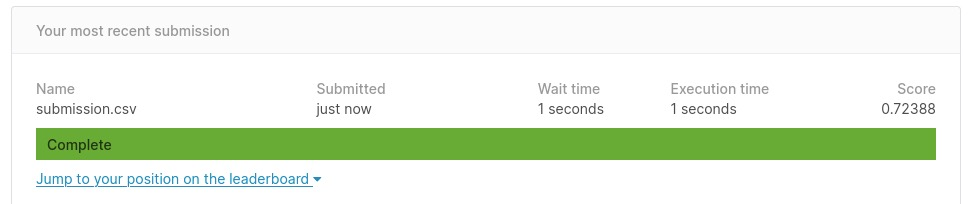

**For Random Forest Classifier**

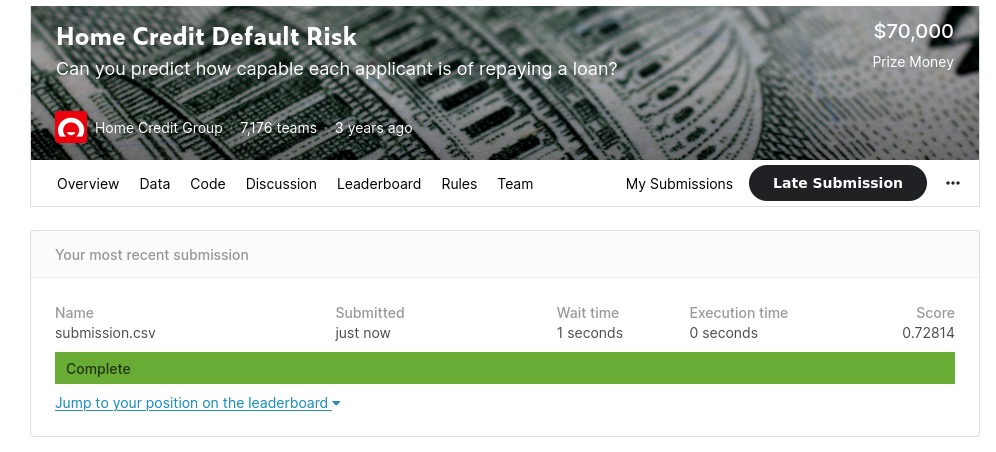

With high training accuracy and a low test accuracy we can see that the Random forest classifier seems to be over fitting and thus the ideal choice of model would be Logistic Regression


# **CONCLUSION**

- The main focus of this project is on predicting whether the credit-less population are able to pay back their loans or not. 
- In order to make this possible I have sourced the data from the Home Credit dataset. 
- It is very important that this population also gets a fair chance of getting a loan and as we being students can highly relate to this. 
- Hence that's why decided to do this project in my Udacity Nanodegree Program as a Capstone project. 
- In previous phase, we understood the data by performing exploratory data analysis.
- After which I pre=processed and cleaned the data.
-  I have featured the data performing OHE and applied imputing methods to fix the data before feeding it to the model.
- In this phase  I have performed feature engineering by adding new columns to the model for improved accuracy and performed hyperparameter tuning to find out the best setting and parameters for the models and was able to achieve the test ROC Score of 72.8% using random forest classifier and training accuracy of 92.4%. 
- I have used Logistic Regression and Random Forests Classifier models. 
- Finally,evaluated the results using accuracy score, log loss, confusion matrix and ROC AUC scores.

References:https://www.kaggle.com/c/home-credit-default-risk/data
